# Descriptive figures

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# paths
data_dir = os.path.abspath('../data')
fig_dir = os.path.abspath('../figures')

In [32]:
# plt.style.use('seaborn-v0_8-dark')
# plt.rcParams["font.family"] = 'times new roman'

# plot formatting
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# minor axis
plt.rcParams['xtick.minor.bottom'] = True

# grid lines
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'both'
plt.rcParams['grid.alpha'] = 0.25
plt.rcParams['grid.linewidth'] = 2

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

pd.set_option('future.no_silent_downcasting', True)

# orders of magnitude
M = 1_000_000
B = 1_000_000_000
T = 1_000_000_000_000

# Canada's trade partners

In [33]:
# trade by trading partners
src = os.path.join(data_dir, 'CA-part.csv')
tp = pd.read_csv(src, index_col=[0, 1, 2])

In [34]:
# EAA https://www.gov.uk/eu-eea.

# European Union
EU = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
    'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
    'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy',
    'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
    'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'
    ]

# European Economic Area (though Canada has no trade with Liechtenstein)
EEA = ['Iceland', 'Liechtenstein', 'Norway'] + EU

# EAA plus UK and Switzerland
EEA_plus = EEA + ['United Kingdom', 'Switzerland']

In [ ]:
# trade series with countries across time
cous = tp.pivot_table(index=['year', 'cou'], values=tp.columns, aggfunc='sum')
cous = cous.reset_index()
cous = cous.sort_values(['year', 'tradebalance'])

cous['cou'] = cous['cou'].str.split(' (', regex=False).str[0]

# make imports negative
cous['imports'] = -cous['imports']

# label EU and EEA countries
cous['eu'] = cous['cou'].isin(EU)
cous['eea'] = cous['cou'].isin(EEA)
cous['eea+'] = cous['cou'].isin(EEA_plus)

eeap = cous.pivot_table(index=['year', 'eea+'], values=tp.columns, aggfunc='sum')
eeap = eeap.reset_index()
eeap = eeap[eeap['eea+']]
eeap = eeap.rename(columns={'eea+' : 'cou'})
eeap['cou'] = 'EEA+'
eeap['eea+'] = True

cous = pd.concat([cous, eeap])
# cous = cous.drop(columns=['eu', 'eea', 'eea+'])


# calculate shares
sdfs = []
cols = tp.columns
share_cols = [c+'share' for c in cols]

for year, sdf in cous.groupby('year'):
    
    cond = sdf['cou'] == 'Total All Countries'
    sdf[share_cols] = sdf[cols] / sdf.loc[cond, cols].iloc[0]

    sdfs.append(sdf)

cous = pd.concat(sdfs)

Saved: /home/qcx201/Projects/CAtrade/figures/03-import_partners.png


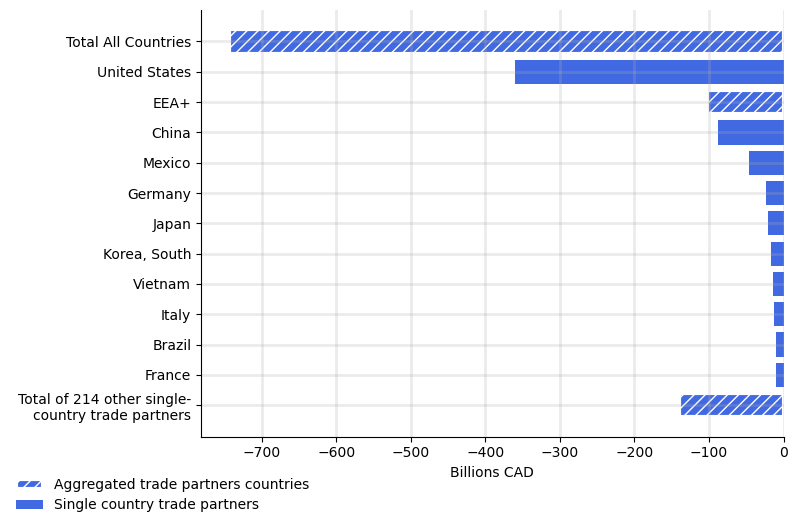

,imports
cou,
Total All Countries,-744.148423
United States,-359.702858
EEA+,-103.101211
China,-88.397183
Mexico,-47.07908
Germany,-23.346134
Japan,-21.118049
"Korea, South",-16.77144
Vietnam,-14.630059


Saved: /home/qcx201/Projects/CAtrade/figures/03-export_partners.png


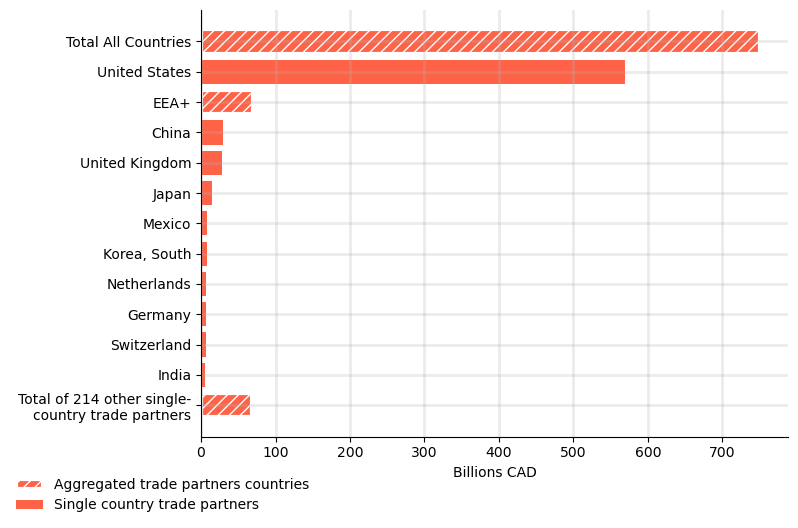

,exports
cou,
Total All Countries,750.702179
United States,569.252073
EEA+,70.248974
China,29.808881
United Kingdom,28.142693
Japan,14.819743
Mexico,8.462675
"Korea, South",7.567014
Netherlands,7.047216


In [91]:
# number of top
top = 10
year = 2024

# trade in latest year
cond = cous['year'] == year
df = cous[cond]

data_dict = {}

# # top net import partners
# title, col = f'Canada\'s top {top} net import partners ({year})', 'tradebalance'
# data = df.sort_values(col)
# cond = data['cou'].str.contains('Total') | data['cou'].str.contains('Import')
# data = data[~cond] # remove totals and reimports for net trade balance rank
# data_dict[title] = {'data' : data, 'col' : col}

# # top net export partners
# title, col = f'Canada\'s top {top} net export partners ({year})', 'tradebalance'
# data = df.sort_values(col, ascending=False)
# cond = data['cou'].str.contains('Total') | data['cou'].str.contains('Import')
# data = data[~cond] # remove totals and reimports for net trade balance rank
# data_dict[title] = {'data' : data, 'col' : col}

# top gross import partners
title, col = f'Canada\'s top {top} (gross) import partners ({year})', 'imports'
data = df.sort_values(col)
data_dict[title] = {'data' : data, 'col' : col}

# top gross export partners
title, col = f'Canada\'s top {top} (gross) export partners ({year})', 'exports'
data = df.sort_values(col, ascending=False)
data_dict[title] = {'data' : data, 'col' : col}


for title, params in data_dict.items():
    
    data = params['data']
    col = params['col']
    
    # add 2 for all countries and EEA+
    nhead = top if 'net' in title else top + 2
    sdf = data.head(nhead)

    others = data.iloc[nhead:]
    nothers = len(others)
    others = others.sum(axis=0).to_frame().T
    others[['year', 'cou']] = 2024, f'Total of {nothers} other single-\ncountry trade partners'
    sdf = pd.concat([sdf, others])

    x, y = sdf['cou'], sdf[col] / B

    fig, ax = plt.subplots(figsize=(8, 5))

    # formatting
    kwargs = {
        'color' : 'tomato' if 'export' in title else 'royalblue',
        'fill' : False if 'net' in title else True,
        'linewidth' : 3
    }
    kwargs['edgecolor'] = kwargs['color'] if 'net' in title else None

    # plot bar
    bars = ax.barh(x, y, **kwargs)

    # ax.set_title(title) # remove title for article
    ax.set_xlabel('Billions CAD')
    
    # fig.text(1, 0, 'Data source: ISED Canada   ', ha='right', va='bottom')

    # add hatch to bar for total all countries export/import
    if 'net' not in title:
        for i in (0, 2, -1):
            bars[i].set_hatch('///')
            bars[i].set_edgecolor('white')

        fig.legend((bars[0], bars[1]), ('Aggregated trade partners countries', 'Single country trade partners'),
                   bbox_to_anchor=(0, 0), loc='center left', frameon=False)

    # invert order of countries
    plt.gca().invert_yaxis()
    
    # save figures
    n = 3 if 'gross' in title else 4
    tag = '_'.join(title.split()[-n:-1])
    file = f'03-{tag}.png'

    fig.tight_layout()

    dst = os.path.join(fig_dir, file)
    plt.savefig(dst, bbox_inches='tight')

    print('Saved:', dst)
    
    plt.show()
    display(pd.DataFrame([x, y]).T.set_index('cou'))

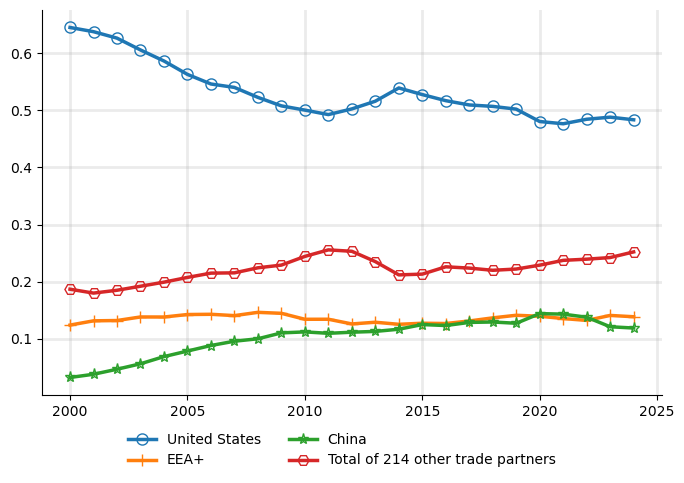

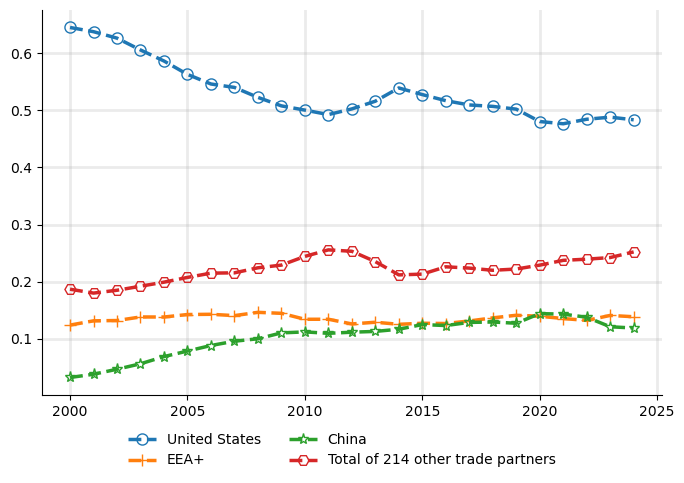

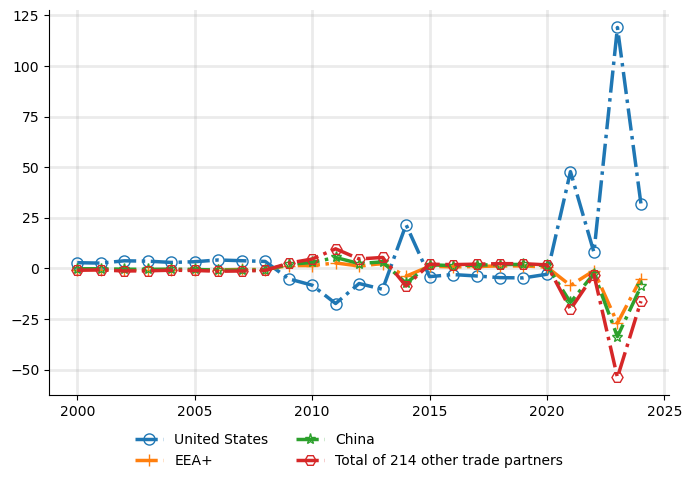

In [114]:
partners = ['United States', 'EEA+', 'China']

# aggregate other trade partners
cond1 = ~(cous['cou'].isin(partners)) # already listed partners
cond2 = ~(cous['eea+'].fillna(True)) # EEA+ countries
cond3 = ~cous['cou'].str.contains('total', case=False) # aggregates
cond4 = ~cous['cou'].str.contains('import', case=False) # re-imports

cond = cond1 & cond2 & cond3 & cond4

sdf = cous[cond]

others = sdf.groupby('year').sum()
others = others.reset_index()

label = f'Total of {nothers:,} other trade partners'
others['cou'] = label
partners.append(label)

# create final dataset
cond = cous['cou'].isin(partners)
data = pd.concat([cous[cond], others])
data = data.sort_values(['year', 'cou'])

cols = ['importsshare', 'importsshare', 'tradebalanceshare']

linestyles = ['-', '--', '-.']
markers = ['o', '+', '*', 'H']

for i, col in enumerate(cols):
    
    fig, ax = plt.subplots(figsize=(8, 5))

    for j, cou in enumerate(partners):
        
        cond = data['cou'] == cou
        x, y = data.loc[cond, 'year'], data.loc[cond, col]

        ax.plot(x, y, lw=2.5, ls=linestyles[i],
                marker=markers[j], markersize=8, fillstyle='none',
                label=cou)

    fig.legend(loc='center', bbox_to_anchor=(0.5, 0), ncol=2, frameon=False)
    
    plt.show()

## What do we trade?

In [ ]:
# Canada's trade by sector/product

## Top trade partners by sector

In [ ]:
# Breakdown trade by sector with top trader